# Project: Image Classification - Guess a Celebrity

## 1. Problem Statement

You and your team are working on improving your facial recognition service. Your company has received a request to use the service you developed at an IT conference where these famous people will be speaking.

To do this, we will train a five-class classifier using the full power of pre-trained networks.

**Project goals:**
* Solving a multi-class classification problem;
* Using the principle of transfer learning;
* Visualization of data and the model's predictions.

And your main goal is to achieve **accuracy > 0.85** on the validation set.

The celebrities in the scope of this task are: Bill Gates, Elon Musk, Jeff Bezos, Mak Zuckerberg and Steve Jobs.

## 2. Import Libraries and Define Constants

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")
import os

import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import random
from tqdm import tqdm

import torch
from torchvision import models
from torchvision import transforms
from torchvision.datasets import ImageFolder

BATCH_SIZE = 64
EPOCHS = 20

# Check if Apple MPS is available
device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cpu")
device


device(type='mps')

## 3. Load Data and Prepare Data

Identify the number of images in the training dataset.

In [2]:
!find data/train/ -type f | wc -l

    3001


The training dataset contains 3000 images. Which is not much compared to the number of images in the ImageNet dataset used to train the pre-trained models.

The scenario can be classified as a small dataset mainly different to what the base network to be used was trained on (since ImageNet is restricting human images).

I will use the following pattern:
1. Remove the last layer of the fully connected network and several CNN layers at the end of the network.
2. Add a new fully connected layer with an output size equal to the number of classes in the new dataset.
3. Freeze all weights from the remaining pre-trained CNN.
4. Update the weights of the new fully connected layer during training.

In [3]:
!find data/valid/ -type f | wc -l

     914


The validation dataset contains 914 images. That constitutes around 23 % of the whole dataset, which is a good ratio.

Loading train and validation datasets using the class `ImageFolder` from the `TorchVision` library.

In [4]:
train_dataset = ImageFolder("data/train/")
valid_dataset = ImageFolder("data/valid/")

# Output one sample from the training dataset
train_dataset[0]

(<PIL.Image.Image image mode=RGB size=70x70>, 0)

The image has the class `PIL.Image` and also there is a class label of the sample. Let's take a look at the class name and the image itself.

bill_gates


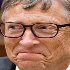

In [5]:
print(train_dataset.classes[train_dataset[0][1]])
train_dataset[0][0]

The label `0` corresponds to the class `bill_gates` and the image is a picture of Bill Gates.

Let's define a function which will render random images from a dataset.

In [6]:
def plot_samples(dataset, num_samples=5):
    fig, axes = plt.subplots(1, num_samples, figsize=(16, 8))

    for i in range(num_samples):
        random_image, random_class = random.choice(dataset)
        random_label = dataset.classes[random_class]
        axes[i].imshow(random_image)
        axes[i].set_title(random_label.replace("_", " "))
        axes[i].axis("off")

    plt.show()

Now I will render five random images.

Train dataset:


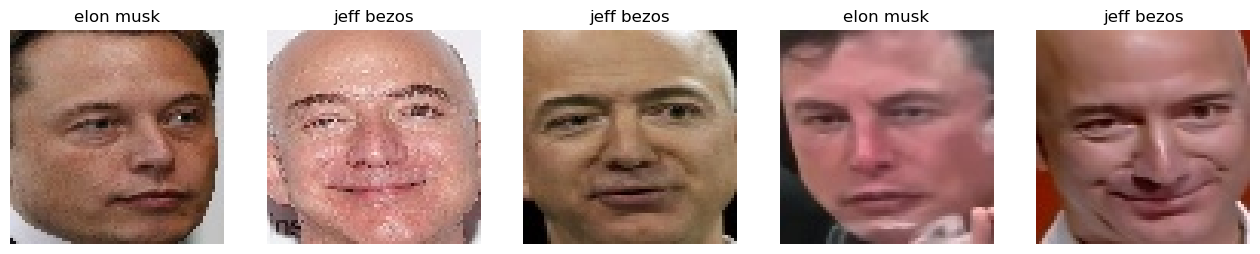

Validation dataset


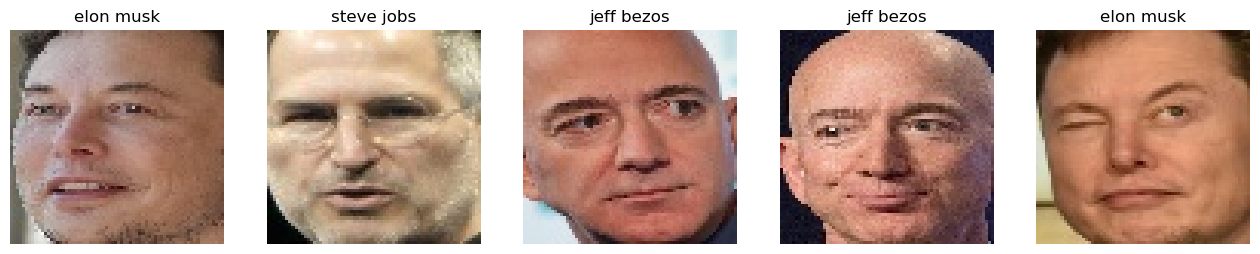

In [7]:
print('Train dataset:')
plot_samples(train_dataset)

print('Validation dataset')
plot_samples(valid_dataset)

To use these datasets in the training process, we apply standard ResNet-style preprocessing to them.

In [8]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

train_dataset.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    normalize
])
valid_dataset.transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    normalize
])

Getting the data loaders ready.

In [9]:
train_loader = torch.utils.data.DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=os.cpu_count()
)

valid_loader = torch.utils.data.DataLoader(
    valid_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=os.cpu_count()
)

## 4. Training the Model

I will use this generic function to train the models for all different types of model architecture I want to experiment with.

In [10]:
def train_model(model, criterion, optimizer, train_loader, valid_loader, num_epochs=10):
    loss_train = []
    top1_train = []
    loss_valid = []
    top1_valid = []

    for epoch in range(num_epochs):
        torch.set_grad_enabled(True)
        model.train()

        losses = []
        equals = []

        for images, target in tqdm(train_loader):
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            loss = criterion(output, target)

            losses.append(loss.item())
            equals.extend([eq.item() for eq in output.argmax(1) == target])

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        loss_train.append(np.mean(losses))
        top1_train.append(np.mean(equals))

        torch.set_grad_enabled(False)
        model.eval()

        losses = []
        equals = []

        for images, target in tqdm(valid_loader):
            images = images.to(device)
            target = target.to(device)

            output = model(images)
            loss = criterion(output, target)

            losses.append(loss.item())
            equals.extend([eq.item() for eq in output.argmax(1) == target])

        loss_valid.append(np.mean(losses))
        top1_valid.append(np.mean(equals))

        print(f'Epoch {epoch + 1}/{num_epochs} - '
              f'Train loss: {loss_train[-1]:.4f}, Train accuracy: {top1_train[-1]:.4f}, '
              f'Valid loss: {loss_valid[-1]:.4f}, Valid accuracy: {top1_valid[-1]:.4f}')

    return loss_train, top1_train, loss_valid, top1_valid

The following function will be used to visually render the training results.

In [11]:
def render_results(loss_train, top1_train, loss_valid, top1_valid):
    plt.figure(figsize=(14, 6))

    plt.subplot(121)
    plt.plot(range(1, len(loss_train) + 1), loss_train, color="b")
    plt.plot(range(1, len(loss_train) + 1), loss_valid, color="r")
    plt.xlabel("Epoch Number")
    plt.title("Loss Function")

    plt.subplot(122)
    plt.plot(range(1, len(loss_train) + 1), top1_train, color="b")
    plt.plot(range(1, len(loss_train) + 1), top1_valid, color="r")
    plt.xlabel("Epoch Number")
    plt.title("Top-1 Accuracy")

    plt.show()

The following function will be used to set-up and train a model.

In [12]:
def set_up_and_train(model, train_loader, valid_loader, lr=1e-2):
    # Freeze the weights of all other layers and train only the final dense layer.
    for parameter in model.parameters():
        parameter.requires_grad = False
    for parameter in model.fc.parameters():
        parameter.requires_grad = True

    # Use Cross Entropy Loss for multi-class classification
    criterion = torch.nn.CrossEntropyLoss()

    # Move the model and criterion to the selected device (MPS/CPU)
    model = model.to(device)
    criterion = criterion.to(device)

    # Use Adam optimizer with weight decay
    # It is important to create it after the model is moved to the device
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)

    # Train the model
    loss_train, top1_train, loss_valid, top1_valid = train_model(model, criterion, optimizer, train_loader, valid_loader, EPOCHS)

    print(f'Maximum validation accuracy: {max(top1_valid):.4f}')
    render_results(loss_train, top1_train, loss_valid, top1_valid)

For training, I will take the lightweight ResNet-34 model from the ResNet family.

In [13]:
model_dense = models.resnet34(pretrained=True)
model_dense

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### 4.1 Replacing the Dense Layer

To apply the first transfer learning strategy to the pre-trained ResNet-34 model, I will start with replaicing the ultimate dense layer `fc` to match the number of classes in this task - 5.

Then set-up and train the model.

100%|██████████| 15/15 [00:56<00:00,  3.77s/it]


Epoch 1/20 - Train loss: 1.3808, Train accuracy: 0.4320, Valid loss: 1.0555, Valid accuracy: 0.6291


100%|██████████| 15/15 [00:55<00:00,  3.68s/it]


Epoch 2/20 - Train loss: 1.0974, Train accuracy: 0.5907, Valid loss: 0.8612, Valid accuracy: 0.7352


100%|██████████| 15/15 [00:54<00:00,  3.65s/it]


Epoch 3/20 - Train loss: 0.9833, Train accuracy: 0.6487, Valid loss: 0.7758, Valid accuracy: 0.7495


100%|██████████| 15/15 [00:54<00:00,  3.65s/it]


Epoch 4/20 - Train loss: 0.9298, Train accuracy: 0.6473, Valid loss: 0.7379, Valid accuracy: 0.7571


100%|██████████| 15/15 [00:54<00:00,  3.64s/it]


Epoch 5/20 - Train loss: 0.8844, Train accuracy: 0.6750, Valid loss: 0.6829, Valid accuracy: 0.7801


100%|██████████| 15/15 [00:54<00:00,  3.64s/it]


Epoch 6/20 - Train loss: 0.8421, Train accuracy: 0.6823, Valid loss: 0.6503, Valid accuracy: 0.7713


100%|██████████| 15/15 [00:54<00:00,  3.66s/it]


Epoch 7/20 - Train loss: 0.8343, Train accuracy: 0.6940, Valid loss: 0.6171, Valid accuracy: 0.8009


100%|██████████| 15/15 [00:54<00:00,  3.63s/it]


Epoch 8/20 - Train loss: 0.8157, Train accuracy: 0.6993, Valid loss: 0.6014, Valid accuracy: 0.7932


100%|██████████| 15/15 [00:54<00:00,  3.63s/it]


Epoch 9/20 - Train loss: 0.7886, Train accuracy: 0.7123, Valid loss: 0.6024, Valid accuracy: 0.7779


100%|██████████| 15/15 [00:54<00:00,  3.63s/it]


Epoch 10/20 - Train loss: 0.8065, Train accuracy: 0.7007, Valid loss: 0.5703, Valid accuracy: 0.8053


100%|██████████| 15/15 [00:54<00:00,  3.63s/it]


Epoch 11/20 - Train loss: 0.7513, Train accuracy: 0.7233, Valid loss: 0.5763, Valid accuracy: 0.7987


100%|██████████| 15/15 [00:54<00:00,  3.64s/it]


Epoch 12/20 - Train loss: 0.7708, Train accuracy: 0.7120, Valid loss: 0.5469, Valid accuracy: 0.8206


100%|██████████| 15/15 [00:54<00:00,  3.63s/it]


Epoch 13/20 - Train loss: 0.7616, Train accuracy: 0.7187, Valid loss: 0.5374, Valid accuracy: 0.8118


100%|██████████| 15/15 [00:54<00:00,  3.63s/it]


Epoch 14/20 - Train loss: 0.7332, Train accuracy: 0.7263, Valid loss: 0.5456, Valid accuracy: 0.8129


100%|██████████| 15/15 [00:54<00:00,  3.64s/it]


Epoch 15/20 - Train loss: 0.7657, Train accuracy: 0.7173, Valid loss: 0.5694, Valid accuracy: 0.7954


100%|██████████| 15/15 [00:54<00:00,  3.63s/it]


Epoch 16/20 - Train loss: 0.7318, Train accuracy: 0.7187, Valid loss: 0.5224, Valid accuracy: 0.8260


100%|██████████| 15/15 [00:54<00:00,  3.63s/it]


Epoch 17/20 - Train loss: 0.7089, Train accuracy: 0.7373, Valid loss: 0.5158, Valid accuracy: 0.8217


100%|██████████| 15/15 [00:54<00:00,  3.63s/it]


Epoch 18/20 - Train loss: 0.7188, Train accuracy: 0.7387, Valid loss: 0.5142, Valid accuracy: 0.8249


100%|██████████| 15/15 [00:55<00:00,  3.67s/it]


Epoch 19/20 - Train loss: 0.7375, Train accuracy: 0.7203, Valid loss: 0.5199, Valid accuracy: 0.8271


100%|██████████| 15/15 [00:55<00:00,  3.67s/it]


Epoch 20/20 - Train loss: 0.7090, Train accuracy: 0.7327, Valid loss: 0.5158, Valid accuracy: 0.8118
Maximum validation accuracy: 0.8271


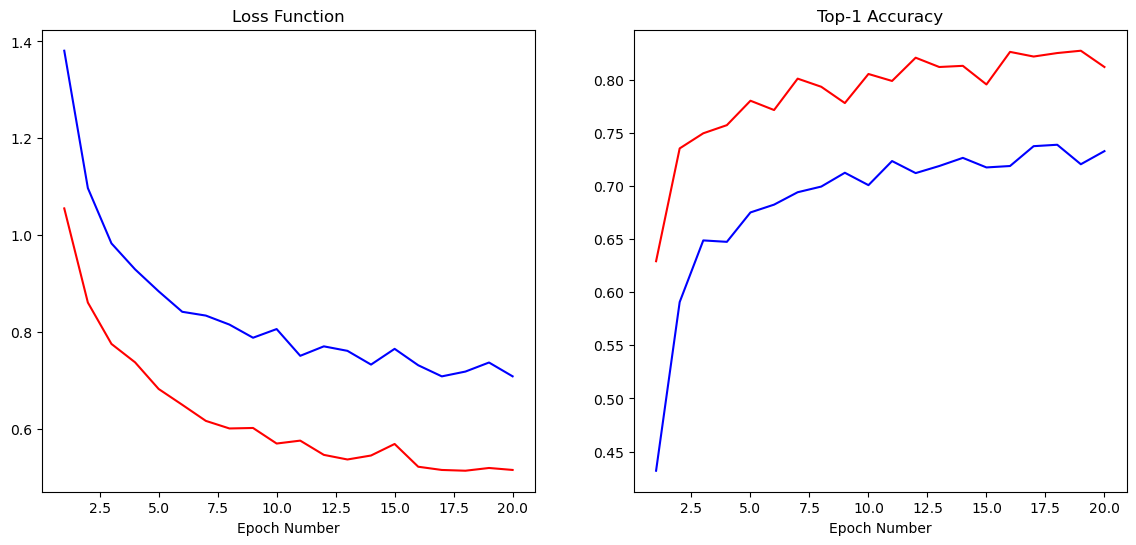

In [14]:
model_dense.fc = torch.nn.Linear(512, len(train_dataset.classes))

set_up_and_train(model_dense, train_loader, valid_loader, 1e-3)

Maximum accuracy achieved with this transfer learning strategy is `0.8271`, which is below the target.

### 4.2 Replacing the Dense Layer and the Last CNN Layer

To apply a second transfer learning strategy to the pre-trained ResNet-34 model, I will:
* Delete the last CNN Layer: `layer4`, `BasicBlock (2)`.
* Replaice the ultimate dense layer `fc` to match the number of classes in this task - 5.

In [15]:
model_cnn1_dense = models.resnet34(pretrained=True)
model_cnn1_dense.layer4 = torch.nn.Sequential(model_cnn1_dense.layer4[:2])
model_cnn1_dense.fc = torch.nn.Linear(512, len(train_dataset.classes))
model_cnn1_dense

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Then set-up and train the model.

100%|██████████| 15/15 [00:54<00:00,  3.63s/it]


Epoch 1/20 - Train loss: 1.3447, Train accuracy: 0.4500, Valid loss: 0.7807, Valid accuracy: 0.7910


100%|██████████| 15/15 [00:54<00:00,  3.67s/it]


Epoch 2/20 - Train loss: 0.9568, Train accuracy: 0.6440, Valid loss: 0.6300, Valid accuracy: 0.8063


100%|██████████| 15/15 [00:55<00:00,  3.70s/it]


Epoch 3/20 - Train loss: 0.8146, Train accuracy: 0.6980, Valid loss: 0.5989, Valid accuracy: 0.7801


100%|██████████| 15/15 [00:55<00:00,  3.67s/it]


Epoch 4/20 - Train loss: 0.7701, Train accuracy: 0.7110, Valid loss: 0.5463, Valid accuracy: 0.7954


100%|██████████| 15/15 [00:54<00:00,  3.65s/it]


Epoch 5/20 - Train loss: 0.7691, Train accuracy: 0.7180, Valid loss: 0.5233, Valid accuracy: 0.8020


100%|██████████| 15/15 [00:55<00:00,  3.68s/it]


Epoch 6/20 - Train loss: 0.7035, Train accuracy: 0.7477, Valid loss: 0.5230, Valid accuracy: 0.7998


100%|██████████| 15/15 [00:54<00:00,  3.66s/it]


Epoch 7/20 - Train loss: 0.7161, Train accuracy: 0.7223, Valid loss: 0.4903, Valid accuracy: 0.8107


100%|██████████| 15/15 [00:54<00:00,  3.67s/it]


Epoch 8/20 - Train loss: 0.6868, Train accuracy: 0.7483, Valid loss: 0.5634, Valid accuracy: 0.7790


100%|██████████| 15/15 [00:55<00:00,  3.67s/it]


Epoch 9/20 - Train loss: 0.7123, Train accuracy: 0.7310, Valid loss: 0.5410, Valid accuracy: 0.7921


100%|██████████| 15/15 [00:55<00:00,  3.70s/it]


Epoch 10/20 - Train loss: 0.6907, Train accuracy: 0.7443, Valid loss: 0.4133, Valid accuracy: 0.8457


100%|██████████| 15/15 [00:56<00:00,  3.74s/it]


Epoch 11/20 - Train loss: 0.6598, Train accuracy: 0.7633, Valid loss: 0.4128, Valid accuracy: 0.8435


100%|██████████| 15/15 [00:55<00:00,  3.67s/it]


Epoch 12/20 - Train loss: 0.6398, Train accuracy: 0.7683, Valid loss: 0.4128, Valid accuracy: 0.8490


100%|██████████| 15/15 [00:55<00:00,  3.72s/it]


Epoch 13/20 - Train loss: 0.6517, Train accuracy: 0.7593, Valid loss: 0.5195, Valid accuracy: 0.7943


100%|██████████| 15/15 [00:56<00:00,  3.74s/it]


Epoch 14/20 - Train loss: 0.6821, Train accuracy: 0.7490, Valid loss: 0.4040, Valid accuracy: 0.8501


100%|██████████| 15/15 [00:55<00:00,  3.72s/it]


Epoch 15/20 - Train loss: 0.6521, Train accuracy: 0.7547, Valid loss: 0.3767, Valid accuracy: 0.8654


100%|██████████| 15/15 [00:55<00:00,  3.69s/it]


Epoch 16/20 - Train loss: 0.6699, Train accuracy: 0.7587, Valid loss: 0.4468, Valid accuracy: 0.8271


100%|██████████| 15/15 [00:55<00:00,  3.70s/it]


Epoch 17/20 - Train loss: 0.6335, Train accuracy: 0.7567, Valid loss: 0.3797, Valid accuracy: 0.8589


100%|██████████| 15/15 [00:55<00:00,  3.70s/it]


Epoch 18/20 - Train loss: 0.6445, Train accuracy: 0.7610, Valid loss: 0.3785, Valid accuracy: 0.8578


100%|██████████| 15/15 [00:54<00:00,  3.64s/it]


Epoch 19/20 - Train loss: 0.6253, Train accuracy: 0.7720, Valid loss: 0.3627, Valid accuracy: 0.8709


100%|██████████| 15/15 [00:55<00:00,  3.67s/it]

Epoch 20/20 - Train loss: 0.6280, Train accuracy: 0.7757, Valid loss: 0.4069, Valid accuracy: 0.8468
Maximum validation accuracy: 0.8709


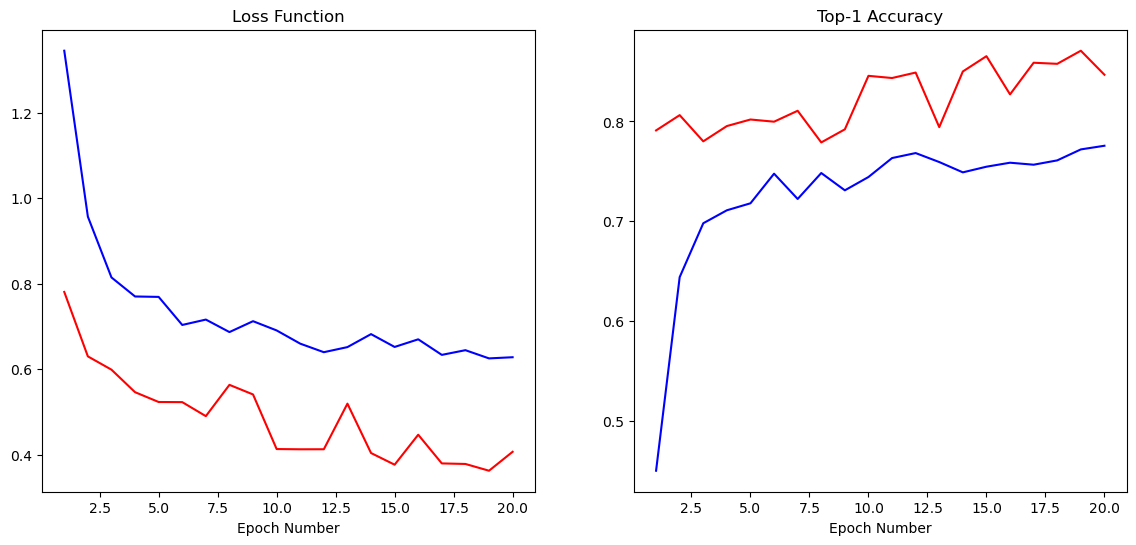

In [16]:
set_up_and_train(model_cnn1_dense, train_loader, valid_loader)

Maximum accuracy achieved with this transfer learning strategy is `0.8709`, which is already above the target. Let's see if a better result can be achieved.

### 4.3 Replacing the Dense Layer and the Last Two CNN Layers

To apply a third transfer learning strategy to the pre-trained ResNet-34 model, I will:
* Delete the last two CNN Layers: `layer4`, `BasicBlock (1) and (2)`.
* Replaice the ultimate dense layer `fc` to match the number of classes in this task - 5.

In [17]:
model_cnn2_dense = models.resnet34(pretrained=True)
model_cnn2_dense.layer4 = torch.nn.Sequential(model_cnn2_dense.layer4[:1])
model_cnn2_dense.fc = torch.nn.Linear(512, len(train_dataset.classes))
model_cnn2_dense

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Then set-up and train the model.

100%|██████████| 15/15 [00:54<00:00,  3.63s/it]


Epoch 1/20 - Train loss: 1.2012, Train accuracy: 0.5257, Valid loss: 0.8184, Valid accuracy: 0.7505


100%|██████████| 15/15 [00:54<00:00,  3.63s/it]


Epoch 2/20 - Train loss: 0.8858, Train accuracy: 0.6800, Valid loss: 0.6591, Valid accuracy: 0.7495


100%|██████████| 15/15 [00:54<00:00,  3.61s/it]


Epoch 3/20 - Train loss: 0.8084, Train accuracy: 0.7057, Valid loss: 0.6022, Valid accuracy: 0.7615


100%|██████████| 15/15 [00:54<00:00,  3.63s/it]


Epoch 4/20 - Train loss: 0.7481, Train accuracy: 0.7340, Valid loss: 0.5307, Valid accuracy: 0.8184


100%|██████████| 15/15 [00:54<00:00,  3.62s/it]


Epoch 5/20 - Train loss: 0.7235, Train accuracy: 0.7353, Valid loss: 0.4672, Valid accuracy: 0.8490


100%|██████████| 15/15 [00:54<00:00,  3.61s/it]


Epoch 6/20 - Train loss: 0.7098, Train accuracy: 0.7407, Valid loss: 0.4457, Valid accuracy: 0.8523


100%|██████████| 15/15 [00:54<00:00,  3.62s/it]


Epoch 7/20 - Train loss: 0.6773, Train accuracy: 0.7520, Valid loss: 0.4668, Valid accuracy: 0.8403


100%|██████████| 15/15 [00:54<00:00,  3.62s/it]


Epoch 8/20 - Train loss: 0.6387, Train accuracy: 0.7747, Valid loss: 0.4434, Valid accuracy: 0.8392


100%|██████████| 15/15 [00:54<00:00,  3.61s/it]


Epoch 9/20 - Train loss: 0.6636, Train accuracy: 0.7483, Valid loss: 0.4306, Valid accuracy: 0.8501


100%|██████████| 15/15 [00:54<00:00,  3.61s/it]


Epoch 10/20 - Train loss: 0.6375, Train accuracy: 0.7770, Valid loss: 0.4001, Valid accuracy: 0.8676


100%|██████████| 15/15 [00:54<00:00,  3.61s/it]


Epoch 11/20 - Train loss: 0.6490, Train accuracy: 0.7637, Valid loss: 0.3834, Valid accuracy: 0.8753


100%|██████████| 15/15 [00:54<00:00,  3.62s/it]


Epoch 12/20 - Train loss: 0.6221, Train accuracy: 0.7720, Valid loss: 0.3987, Valid accuracy: 0.8654


100%|██████████| 15/15 [00:54<00:00,  3.62s/it]


Epoch 13/20 - Train loss: 0.6330, Train accuracy: 0.7613, Valid loss: 0.3729, Valid accuracy: 0.8884


100%|██████████| 15/15 [00:54<00:00,  3.61s/it]


Epoch 14/20 - Train loss: 0.5784, Train accuracy: 0.7887, Valid loss: 0.3545, Valid accuracy: 0.8851


100%|██████████| 15/15 [00:54<00:00,  3.61s/it]


Epoch 15/20 - Train loss: 0.5974, Train accuracy: 0.7840, Valid loss: 0.3773, Valid accuracy: 0.8611


100%|██████████| 15/15 [00:54<00:00,  3.62s/it]


Epoch 16/20 - Train loss: 0.5894, Train accuracy: 0.7873, Valid loss: 0.3716, Valid accuracy: 0.8654


100%|██████████| 15/15 [00:54<00:00,  3.62s/it]


Epoch 17/20 - Train loss: 0.5735, Train accuracy: 0.7867, Valid loss: 0.3325, Valid accuracy: 0.8972


100%|██████████| 15/15 [00:54<00:00,  3.61s/it]


Epoch 18/20 - Train loss: 0.5616, Train accuracy: 0.7957, Valid loss: 0.3613, Valid accuracy: 0.8786


100%|██████████| 15/15 [00:54<00:00,  3.63s/it]


Epoch 19/20 - Train loss: 0.5567, Train accuracy: 0.8043, Valid loss: 0.3299, Valid accuracy: 0.8950


100%|██████████| 15/15 [00:54<00:00,  3.62s/it]

Epoch 20/20 - Train loss: 0.5922, Train accuracy: 0.7800, Valid loss: 0.3185, Valid accuracy: 0.8884
Maximum validation accuracy: 0.8972


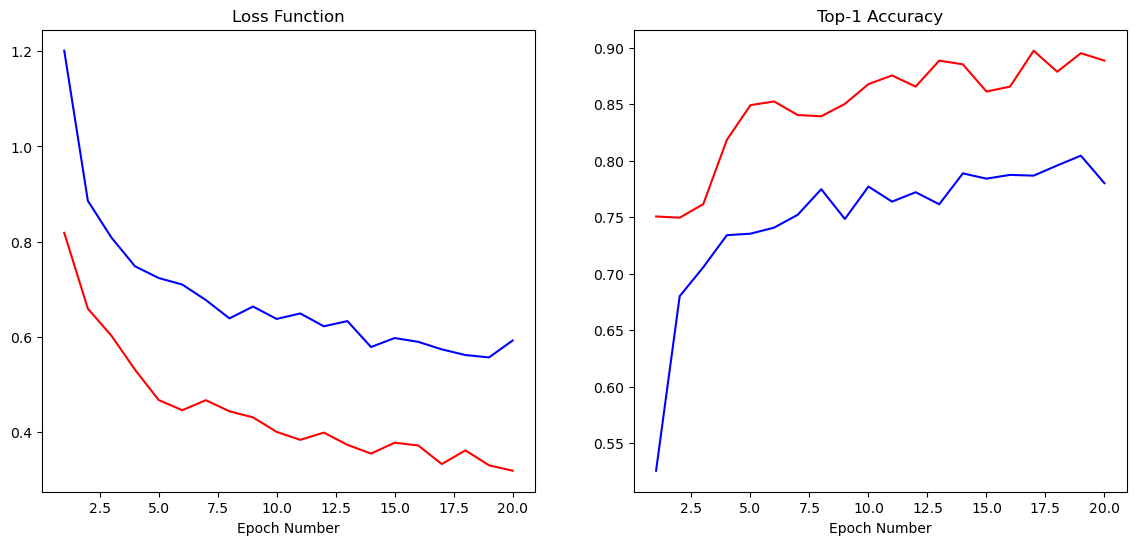

In [18]:
set_up_and_train(model_cnn2_dense, train_loader, valid_loader)

Maximum accuracy achieved with this transfer learning strategy is `0.8972`, which is significantly above the target.

### 4.4 Replacing the Dense Layer and the Last Residual Layer

To apply a fourth transfer learning strategy to the pre-trained ResNet-34 model, I will:
* Delete the last residual layer: `layer4`, consisting of three CNN Layers.
* Replaice the ultimate dense layer `fc` to match the number of classes in this task - 5.

In [25]:
model_layer4_dense = models.resnet34(pretrained=True)
model_layer4_dense.layer4 = torch.nn.Identity()
model_layer4_dense.fc = torch.nn.Linear(256, len(train_dataset.classes))
model_layer4_dense

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Then set-up and train the model.

100%|██████████| 15/15 [00:54<00:00,  3.66s/it]


Epoch 1/20 - Train loss: 1.5124, Train accuracy: 0.3460, Valid loss: 1.3496, Valid accuracy: 0.4726


100%|██████████| 15/15 [00:54<00:00,  3.65s/it]


Epoch 2/20 - Train loss: 1.3577, Train accuracy: 0.4937, Valid loss: 1.2319, Valid accuracy: 0.5131


100%|██████████| 15/15 [00:54<00:00,  3.67s/it]


Epoch 3/20 - Train loss: 1.2549, Train accuracy: 0.5820, Valid loss: 1.1177, Valid accuracy: 0.6379


100%|██████████| 15/15 [00:55<00:00,  3.70s/it]


Epoch 4/20 - Train loss: 1.1814, Train accuracy: 0.6083, Valid loss: 1.0322, Valid accuracy: 0.6718


100%|██████████| 15/15 [00:55<00:00,  3.73s/it]


Epoch 5/20 - Train loss: 1.1424, Train accuracy: 0.5957, Valid loss: 0.9874, Valid accuracy: 0.6597


100%|██████████| 15/15 [00:54<00:00,  3.65s/it]


Epoch 6/20 - Train loss: 1.0860, Train accuracy: 0.6210, Valid loss: 0.9193, Valid accuracy: 0.7221


100%|██████████| 15/15 [00:55<00:00,  3.72s/it]


Epoch 7/20 - Train loss: 1.0425, Train accuracy: 0.6733, Valid loss: 0.8958, Valid accuracy: 0.6991


100%|██████████| 15/15 [00:55<00:00,  3.69s/it]


Epoch 8/20 - Train loss: 1.0087, Train accuracy: 0.6730, Valid loss: 0.8461, Valid accuracy: 0.7681


100%|██████████| 15/15 [00:55<00:00,  3.68s/it]


Epoch 9/20 - Train loss: 0.9845, Train accuracy: 0.6737, Valid loss: 0.8254, Valid accuracy: 0.7812


100%|██████████| 15/15 [00:55<00:00,  3.73s/it]


Epoch 10/20 - Train loss: 0.9687, Train accuracy: 0.6763, Valid loss: 0.8070, Valid accuracy: 0.7473


100%|██████████| 15/15 [00:54<00:00,  3.65s/it]


Epoch 11/20 - Train loss: 0.9565, Train accuracy: 0.6810, Valid loss: 0.7814, Valid accuracy: 0.7691


100%|██████████| 15/15 [00:55<00:00,  3.68s/it]


Epoch 12/20 - Train loss: 0.9252, Train accuracy: 0.7023, Valid loss: 0.7552, Valid accuracy: 0.7888


100%|██████████| 15/15 [00:56<00:00,  3.79s/it]


Epoch 13/20 - Train loss: 0.9000, Train accuracy: 0.7237, Valid loss: 0.7392, Valid accuracy: 0.7691


100%|██████████| 15/15 [00:56<00:00,  3.77s/it]


Epoch 14/20 - Train loss: 0.8935, Train accuracy: 0.7097, Valid loss: 0.7199, Valid accuracy: 0.7943


100%|██████████| 15/15 [00:55<00:00,  3.68s/it]


Epoch 15/20 - Train loss: 0.8908, Train accuracy: 0.7157, Valid loss: 0.7044, Valid accuracy: 0.7965


100%|██████████| 15/15 [00:56<00:00,  3.75s/it]


Epoch 16/20 - Train loss: 0.8560, Train accuracy: 0.7147, Valid loss: 0.7052, Valid accuracy: 0.7954


100%|██████████| 15/15 [00:56<00:00,  3.74s/it]


Epoch 17/20 - Train loss: 0.8648, Train accuracy: 0.7150, Valid loss: 0.6765, Valid accuracy: 0.8063


100%|██████████| 15/15 [00:55<00:00,  3.71s/it]


Epoch 18/20 - Train loss: 0.8366, Train accuracy: 0.7380, Valid loss: 0.6741, Valid accuracy: 0.7965


100%|██████████| 15/15 [00:55<00:00,  3.69s/it]


Epoch 19/20 - Train loss: 0.8471, Train accuracy: 0.7110, Valid loss: 0.6589, Valid accuracy: 0.8217


100%|██████████| 15/15 [00:56<00:00,  3.76s/it]


Epoch 20/20 - Train loss: 0.8235, Train accuracy: 0.7297, Valid loss: 0.6497, Valid accuracy: 0.7943
Maximum validation accuracy: 0.8217


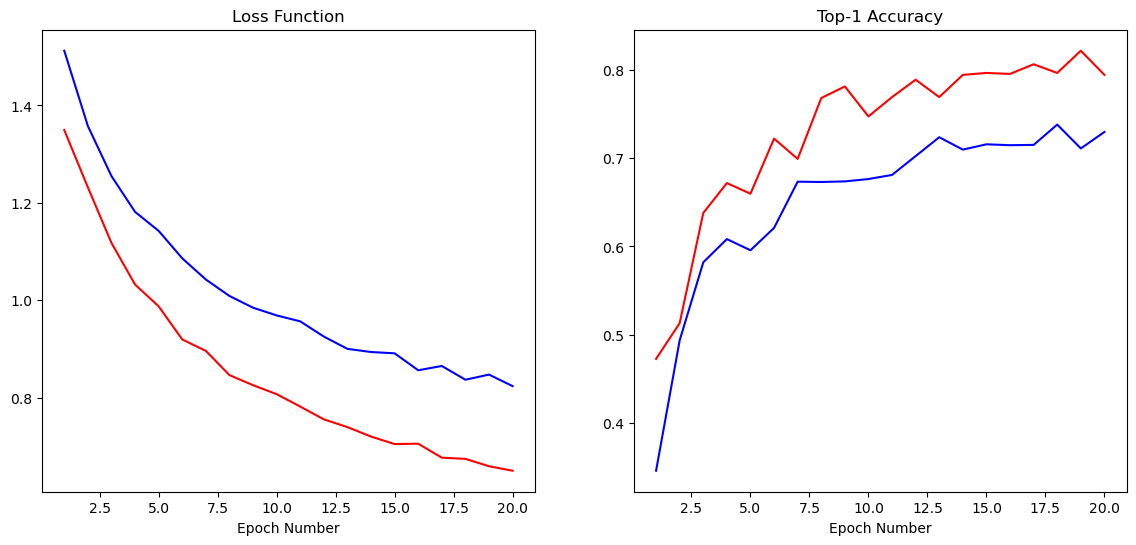

In [26]:
set_up_and_train(model_layer4_dense, train_loader, valid_loader)

Maximum accuracy achieved with this transfer learning strategy is `0.8235`, which is below the target and also below other previous strategies.

## 5. Predictions by the Trained Models

Let's use the best of the models to predict the classes of two independent images.

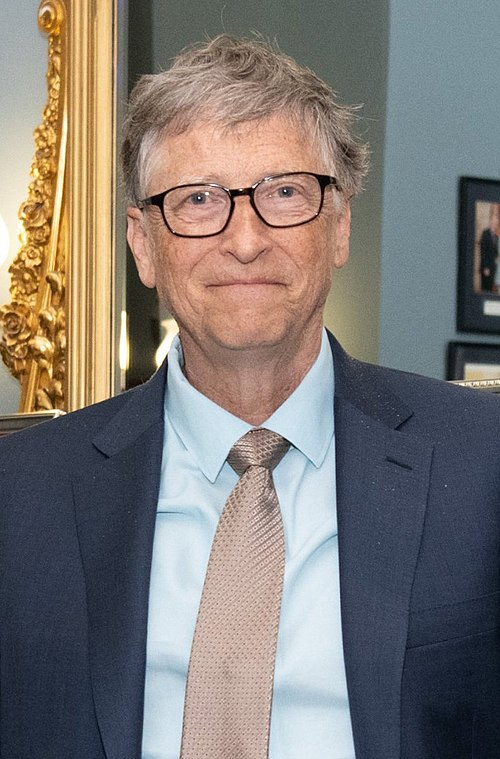

In [19]:
image_bill_gates = Image.open("data/Bill_Gates.jpg")
image_bill_gates

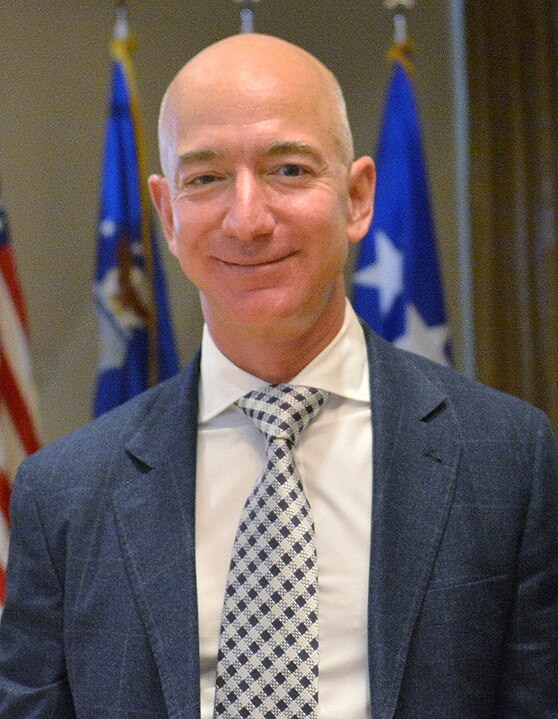

In [20]:
image_jeff_bezos = Image.open("data/Jeff_Bezos.jpg")
image_jeff_bezos

The following function predicts the image class.

In [21]:
def predict_image_class(image):
    tensor = valid_dataset.transform(image)
    batch = torch.stack([tensor])
    with torch.no_grad():
        output = model_cnn2_dense(batch.to(device))
    predicted = output.argmax().item()
    return train_dataset.classes[predicted]

Now let's predict the classes of the loaded images.

In [22]:
print('Predicting Bill Gates image class:')
print(predict_image_class(image_bill_gates))

print('Predicting Jeff Bezos image class:')
print(predict_image_class(image_jeff_bezos))

Predicting Bill Gates image class:
bill_gates
Predicting Jeff Bezos image class:
jeff_bezos


The trained network successfully recognized the images.

Just for fun I will use the recognition for my own picture and see to which of the classes I am the closest.

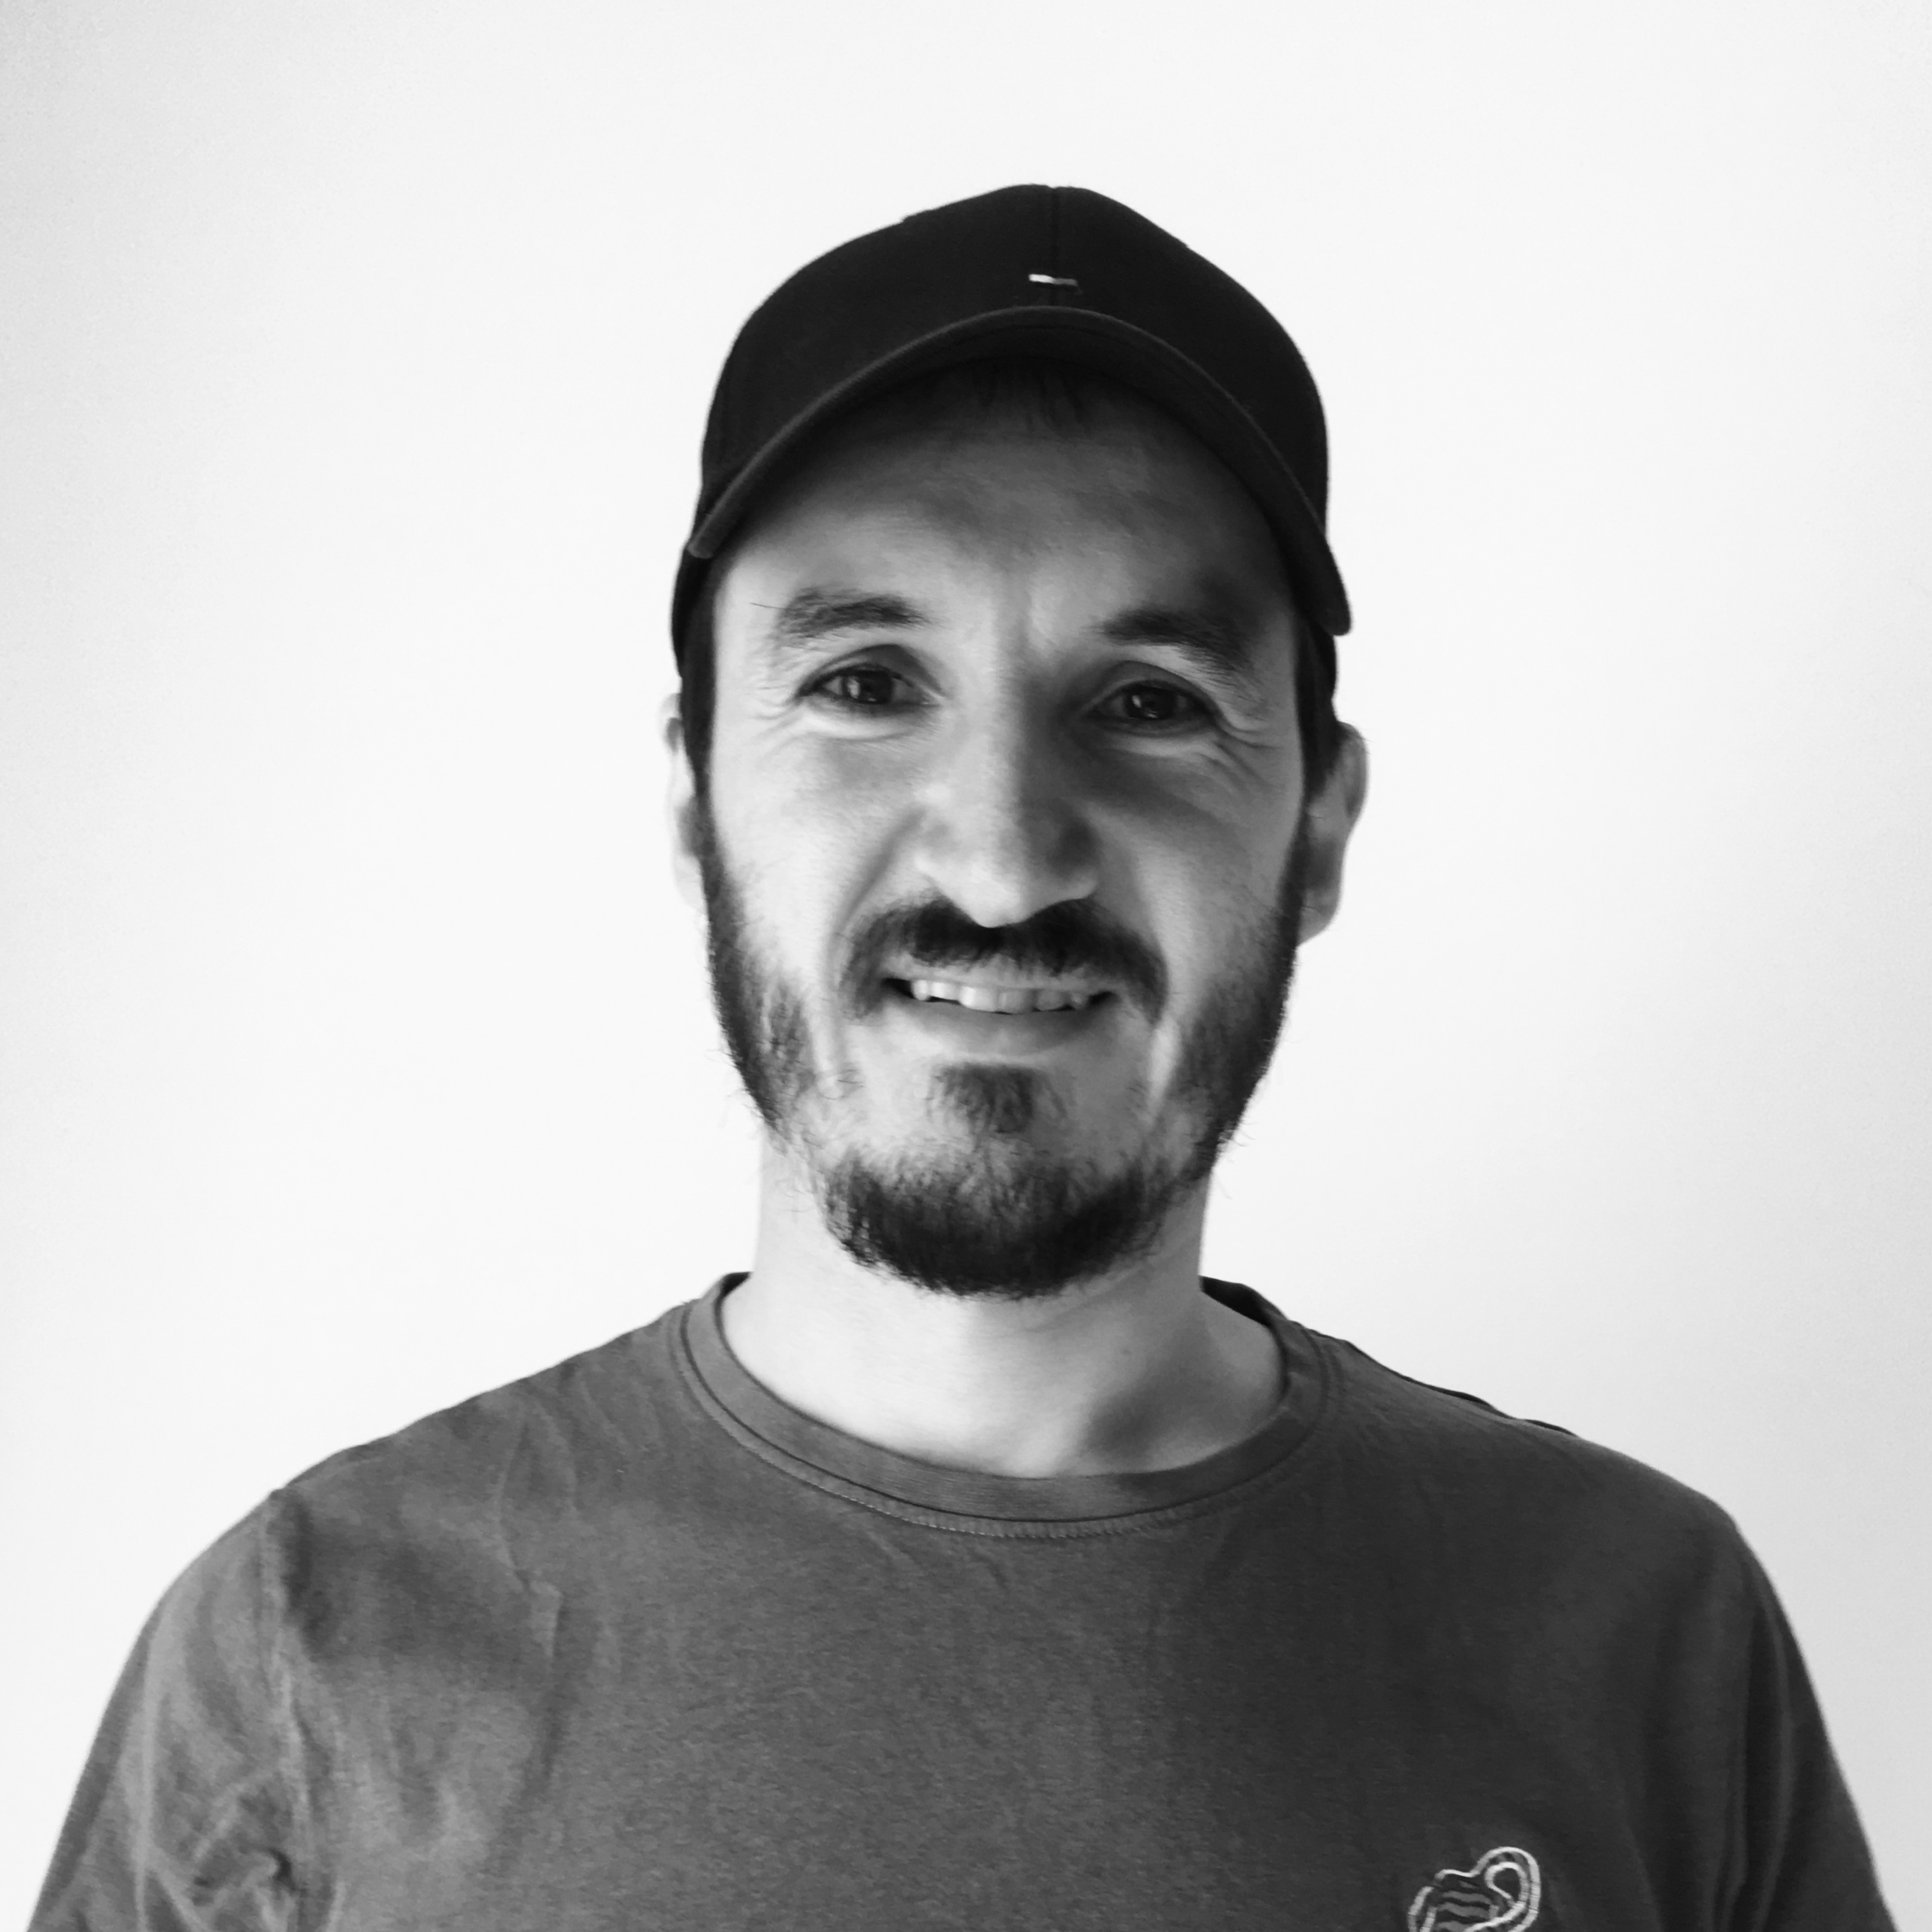

In [23]:
image_dmitriy_golubitskiy = Image.open("data/Dmitriy_Golubitskiy.jpg")
image_dmitriy_golubitskiy

In [24]:
print('Predicting Dmitriy Golubitskiy image class:')
print(predict_image_class(image_dmitriy_golubitskiy))

Predicting Dmitriy Golubitskiy image class:
jeff_bezos


Optically from the five celebrities in the scope I look most alike with Jeff Bezoz.

## 6. Final Conclusion

The best result with the accuracy `0.8972` has been achieved on the model where two last CNN Layers have been removed from the last residual layer. This means that these were exactly the layers which contained the high level information of the pretraining dataset and which were irrelevant for the current dataset. All other used transfer learning strategies either removed too much of the high level details of too little of them.

This result does not mean that this approach will universally be applicable, rather every single project would require its own level of fine-tuning.